

**Profesor**: Denis Parra

**Ayudante**: Álvaro Labarca.


# Tarea 2 - MAN3160

En esta tarea, utilizaremos la librería Implicit vista en los tutoriales del curso para comparar el rendimiento de los modelos ALS y BPR.
Para realizar la tarea, deberán leer y ejecutar todas las celdas del notebook y completar/responder las actividades que serán dadas.

## Descarga del dataset

Al igual que en la tarea 1 y los tutoriales del curso, vamos a descargar el dataset [MovieLens-100k](https://grouplens.org/).

Podemos descargar el dataset directamente con el comando wget.

In [ ]:
!pip install wget
!pip install zipfile36
!pip3 install implicit --upgrade
!python -m wget http://files.grouplens.org/datasets/movielens/ml-100k.zip

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=456159c511dd42b16cc172e691d2eee82e0a5f5ebc230c9ee06e4cbc2d7d4630
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 53.0 MB/s eta 0:00:00

Saved under ml-100k.zip


In [1]:
import zipfile
with zipfile.ZipFile("ml-100k.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import numpy as np
import implicit
import scipy.sparse as sparse
import time

In [3]:
train_dir = "ml-100k/u3.base"
test_dir = "ml-100k/u3.test"

In [4]:
import pandas as pd

train_file = pd.read_csv(train_dir, sep='\t', names = ['userid', 'itemid', 'rating', 'timestamp'], header=None)
test_file = pd.read_csv(test_dir, sep='\t', names=['userid', 'itemid', 'rating', 'timestamp'], header=None)
display(train_file.head())
display(test_file.head())



,userid,itemid,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,6,5,887431973


,userid,itemid,rating,timestamp
0,1,5,3,889751712
1,1,11,2,875072262
2,1,16,5,878543541
3,1,25,4,875071805
4,1,35,1,878542420


In [5]:
info_cols = [ 'movieid', 'title', 'release_date', 'video_release_date', 'IMDb_URL', \
              'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', \
              'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', \
              'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western' ]

pd.options.display.max_columns = None

info_file = pd.read_csv('ml-100k/u.item', sep='|', index_col = 0, names = info_cols, header=None, encoding='latin-1')

info_file.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


## Funciones

In [6]:
# Definicion de métricas (No editar)
# Obtenido de https://gist.github.com/bwhite/3726239

def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)

def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])

def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.


def ndcg_at_k(r, k):
    idcg = dcg_at_k(sorted(r, reverse=True), k)

    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

In [7]:
def evaluate_model(model, n):
    mean_map = 0.
    mean_ndcg = 0.
    for u in user_items_test.keys():
        rec = model.recommend(user_ids[u], user_item_matrix[user_ids[u]], n)[0]
        rec = [itemset[r] for r in rec]
        rel_vector = [np.isin(rec, user_items_test[u], assume_unique=True).astype(int)]
        mean_map += mean_average_precision(rel_vector)
        mean_ndcg += ndcg_at_k(rel_vector, n)

    mean_map /= len(user_items_test)
    mean_ndcg /= len(user_items_test)

    return mean_map, mean_ndcg

In [8]:
def show_recommendations(model, user, n):
    recommendations = model.recommend(userid=user_ids[user], user_items=user_item_matrix[user_ids[user]], N=n)
    return df_items.loc[recommendations[0]]['title']

# Actividades

### Actividad 1: Preparación del dataset

Prepare el dataset para que este pueda ser utilizado por los algoritmos de la librería Implicit. (Puede utilizar de base los tutoriales del curso), hasta generar la matriz user_items en formato csr. Puede importar/utilizar cualquier librería adicional que desée.

#### Respuesta:

Ingrese su respuesta en código a continuación. Puede utilizar todas las celdas de código que estime necesaria. Al finalizar, añada una celda de texto (Markdown en Jupyter) explicando qué contiene la matriz csr generada, qué representan sus columnas, sus filas y sus celdas internas.

In [9]:
#Transformo las calificaciones, en el archivo de entrenamiento y test, para que sean implícitas de la siguiente manera:
# rating >= 3 , relevante (1) y rating menor a 3 es no relevante (0)
train_file.rating = [1 if x >=3 else 0 for x in train_file.rating]
test_file.rating = [1 if x >= 3 else 0 for x in test_file.rating ]

display(train_file.head())
display(test_file.head())

,userid,itemid,rating,timestamp
0,1,1,1,874965758
1,1,2,1,876893171
2,1,3,1,878542960
3,1,4,1,876893119
4,1,6,1,887431973


,userid,itemid,rating,timestamp
0,1,5,1,889751712
1,1,11,0,875072262
2,1,16,1,878543541
3,1,25,1,875071805
4,1,35,0,878542420


In [10]:
# Comprobar la cantidad de usuarios e items en los datos de entrenamiento y test

unique_user_ids_train = train_file['userid'].unique()
unique_item_ids_train = train_file['itemid'].unique()

print("Cantidad de valores únicos de usuarios en el conjunto de entrenamiento:", len(unique_user_ids_train))
print("Cantidad de valores únicos de items en el conjunto de entrenamiento:", len(unique_item_ids_train))

unique_user_ids_test = test_file['userid'].unique()
unique_item_ids_test = test_file['itemid'].unique()

print("Cantidad de valores únicos de usuarios en el conjunto de test:", len(unique_user_ids_test))
print("Cantidad de valores únicos de items en el conjunto de test:", len(unique_item_ids_test))

Cantidad de valores únicos de usuarios en el conjunto de entrenamiento: 943
Cantidad de valores únicos de items en el conjunto de entrenamiento: 1650
Cantidad de valores únicos de usuarios en el conjunto de test: 869
Cantidad de valores únicos de items en el conjunto de test: 1423


In [11]:
# Preprocesar los datos de entrenamiento a formato sparse

# Inicializa un diccionario para almacenar los items que cada usuario ha interactuado
user_items = {}

# Inicializa un conjunto para almacenar todos los items únicos que aparecen en los datos
itemset = set()

# Recorre cada fila del dataframe 'df_train'
for row in train_file.itertuples():
    # Si el usuario (row[1]) no está en el diccionario user_items, añade el usuario con una lista vacía
    if row[1] not in user_items:
        user_items[row[1]] = []

    # Añade el item (row[2]) a la lista de items del usuario correspondiente
    user_items[row[1]].append(row[2])

    # Añade el item a itemset, asegurando que todos los items sean únicos
    itemset.add(row[2])

# Convierte itemset en un array numpy ordenado
itemset = np.sort(list(itemset))

# Crea una matriz de ceros con dimensiones [número de usuarios] x [número de items únicos]
sparse_matrix = np.zeros((len(user_items), len(itemset)))

# Recorre los items de cada usuario para crear una fila en la matriz
for i, items in enumerate(user_items.values()):
    # Marca con 1 los items que el usuario ha interactuado en la matriz dispersa
    sparse_matrix[i] = np.isin(itemset, items, assume_unique=True).astype(int)

# Convierte la matriz de numpy a una matriz CSR (Compressed Sparse Row) para optimizar almacenamiento y operaciones
user_item_matrix = sparse.csr_matrix(sparse_matrix)

# Crea un diccionario para mapear IDs de usuarios a índices de filas en la matriz
user_ids = {key: i for i, key in enumerate(user_items.keys())}

# Crea un diccionario para mapear IDs de items a índices de columnas en la matriz
items_ids = {key: i for i, key in enumerate(itemset)}

In [12]:
# Tamaño de la matriz usuario-item y en formato sparse
print(user_item_matrix.shape)
print(sparse_matrix.shape)

(943, 1650)
(943, 1650)


In [13]:
# Comparo el contenido de la matriz usuario item (sparse_matriz) y la matriz en formato sparse (user_item_matrix)

print(sparse_matrix[0:2, 0:15])  #Muestro los primeros 15 items del primer y segundo usuario (fila 0 y 1)
print(user_item_matrix[0:2, 0:15])  #Muestro los primeros 15 items del primer y segundo usuario (fila 0 y 1)



[[1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0.]]
  (0, 0)	1.0
  (0, 1)	1.0
  (0, 2)	1.0
  (0, 3)	1.0
  (0, 5)	1.0
  (0, 6)	1.0
  (0, 7)	1.0
  (0, 8)	1.0
  (0, 9)	1.0
  (0, 11)	1.0
  (0, 12)	1.0
  (0, 13)	1.0
  (0, 14)	1.0
  (1, 0)	1.0
  (1, 9)	1.0
  (1, 12)	1.0
  (1, 13)	1.0


La matriz usuario-item (llamada en este caso sparse.matrix) es una representación donde cada fila corresponde a un usuario y cada columna a un item o película. Un valor de 1 indica que el usuario considera relevante ese item (pues le puso una clificación mayor o igual a 3), mientras que un 0 indica lo contrario.

Por otro lado, la matriz sparse (llamada user_item_matrix) optimiza el espacio al almacenar únicamente las posiciones de los elementos no nulos (unos en este caso) de la matriz original usuario-item. Por ejemplo, si en la posición (0,0) de la matriz usuario-item hay un 1, significa que el primer usuario considera relevante el primer item. En la matriz sparse, esta relación se representaría como una tupla (0,0). De manera similar, se almacenan las posiciones de los items relevantes para otros usuarios, evitando así almacenar todos los vectores binarios de usuarios para cada item.

Por ejemplo, si el primer usuario considera relevantes los items 2, 3 y 4 (posiciones 1, 2 y 3 en la matriz usuario-item), en la matriz sparse se almacenarían las tuplas (0,1), (0,2) y (0,3) para indicar esta relación, mientras que los items irrelevantes para ese usuario no se almacenan, ahorrando espacio de almacenamiento. Como se observa en la matriz, el primer usuario no considera relevante el item 5 y por ello no se almacena la tupla (0,4). Luego se almacenan las tuplas (0,5), (0,6), (0,7), (0,8) y (0,9), pues los items 6,7,8,9 y 10 son relevantes para el primer usuario. Luego, el item 11 no es relevante y finalmente desde el 12 al 15 si lo son.

Para el usuario 1 se guardan las coordenadas  (1, 0), (1, 9), (1, 12) y  (1, 13) pues los items relevantes para este usuario son el 1, 10, 13 y 14 como se observa en la segunda fila de la matriz usuario-item.


### Actividad 2: Entrenamiento de modelo ALS

Entrene el modelo ALS con el set de entrenamiento y realice un estudio de hiperparámetros sobre al menos 2 hiperparámetros del modelo. Despliegue el gráfico sobre la variación del rendimiento (en base a las métricas nDCG y MAP) según el valor del hiperparámetro y explique explícitamente la forma de los gráficos, las conclusiones obtenidas de ellos y la mejor combinación de hiperparámetros en su opinión. Registre y haga un gráfico del tiempo de entrenamiento de cada método. Se recomienda usar la librería _time_ para esto.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de código con sus conclusiones y respuestas.

In [14]:
# Creamos la matriz de usuario-item para el conjunto de test (prueba)

# rating >= 3 es relevante (1) y rating menor a 3 es no relevante (0)
df_test = test_file.copy()

user_items_test = {}
itemset_test = set()

# Creamos un diccionario con los items de test para cada usuario
for row in df_test.itertuples():
    if row[3]:
        if row[1] not in user_items_test:
            user_items_test[row[1]] = []

        user_items_test[row[1]].append(row[2])
        itemset_test.add(row[2])

itemset_test = np.sort(list(itemset_test))

# Creamos la matriz csr user-item para los datos de test
sparse_matrix_test = np.zeros((len(user_items_test), len(itemset_test)))

for i, items in enumerate(user_items_test.values()):
    sparse_matrix_test[i] = np.isin(itemset_test, items, assume_unique=True).astype(int)

user_item_matrix_test = sparse.csr_matrix(sparse_matrix_test)

print(user_item_matrix_test.shape)  #Dimension de la matriz sparse del conjunto de test
print(sparse_matrix_test.shape)  #Dimension de la matriz sparse del conjunto de test

(866, 1301)
(866, 1301)


In [15]:
# Utilizamos los siguientes hiperparámetros para el entrenamiento de ALS:
# Factores latentes
# Factor de regularización

factores_als = [i*5 for i in range(1, 11)]
reg_fac_als = [0.01, 0.02, 0.05, 0.07, 0.1, 0.2, 0.5]


In [16]:
# Creamos un decorador para calcular el tiempo de ejecución al entrenar un modelo
import time

def timer(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f"Tiempo de ejecución (s): {end-start}")
        return result, end-start
    return wrapper

In [17]:
# Creamos una función para entrenar un modelo y le aplicamos el decorador de tiempo
@timer
def train_model(model):
    model.fit(user_item_matrix, show_progress=False)
    return model

# Entrenamos bajo los hiperparámetros definidos y evaluamos sobre una lista de recomendaciones de largo 10
n = 10

map_f_als = []
ndcg_f_als = []

map_rg_als = []
ndcg_rg_als = []

train_times_f_als = []
train_times_rg_als = []

for f in factores_als:
    print('Training model with', f, 'latent factors')
    model_als = implicit.als.AlternatingLeastSquares(factors=f)
    model_als, train_time_f = train_model(model_als)
    mmap, ndcg = evaluate_model(model_als, n)
    map_f_als.append(mmap)
    ndcg_f_als.append(ndcg)
    train_times_f_als.append(train_time_f)
    print('')

for rg in reg_fac_als:
    print('Training model with', rg, 'regularization factor')
    model_als = implicit.als.AlternatingLeastSquares(regularization=rg)
    model_als, train_time_rg = train_model(model_als)
    mmap, ndcg = evaluate_model(model_als, n)
    map_rg_als.append(mmap)
    ndcg_rg_als.append(ndcg)
    train_times_rg_als.append(train_time_rg)
    print()

Training model with 5 latent factors


/opt/homebrew/lib/python3.11/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 10 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


Tiempo de ejecución (s): 0.39282727241516113

Training model with 10 latent factors
Tiempo de ejecución (s): 0.21120309829711914

Training model with 15 latent factors
Tiempo de ejecución (s): 0.5241727828979492

Training model with 20 latent factors
Tiempo de ejecución (s): 0.46477794647216797

Training model with 25 latent factors
Tiempo de ejecución (s): 0.5493412017822266

Training model with 30 latent factors
Tiempo de ejecución (s): 0.5610208511352539

Training model with 35 latent factors
Tiempo de ejecución (s): 0.6851370334625244

Training model with 40 latent factors
Tiempo de ejecución (s): 0.6000618934631348

Training model with 45 latent factors
Tiempo de ejecución (s): 0.8279333114624023

Training model with 50 latent factors
Tiempo de ejecución (s): 1.3444278240203857

Training model with 0.01 regularization factor
Tiempo de ejecución (s): 1.6086599826812744

Training model with 0.02 regularization factor
Tiempo de ejecución (s): 1.8041272163391113

Training model with 0

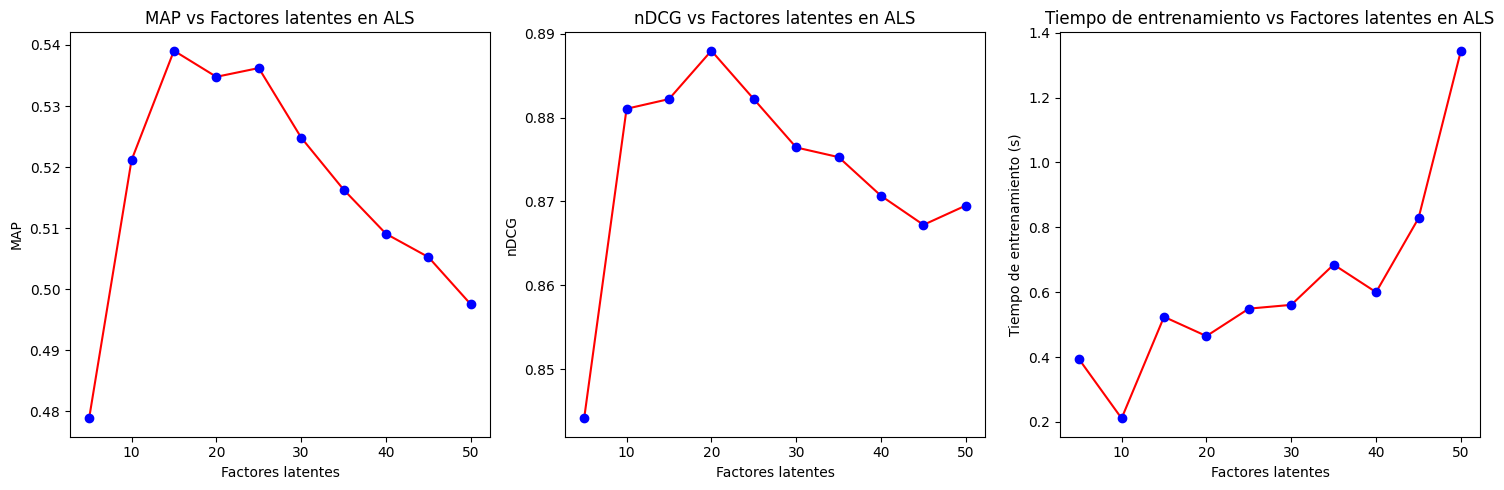

In [18]:
# Crear el grafico para las dos metricas de rendimiento y el tiempo de entrenamiento
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Grafico map
axs[0].plot(factores_als, map_f_als, 'r-')
axs[0].plot(factores_als, map_f_als, 'bo')
axs[0].set_title('MAP vs Factores latentes en ALS')
axs[0].set_xlabel('Factores latentes')
axs[0].set_ylabel('MAP')

# Grafico ndcg
axs[1].plot(factores_als, ndcg_f_als, 'r-')
axs[1].plot(factores_als, ndcg_f_als, 'bo')
axs[1].set_title('nDCG vs Factores latentes en ALS')
axs[1].set_xlabel('Factores latentes')
axs[1].set_ylabel('nDCG')

# Grafico time
axs[2].plot(factores_als, train_times_f_als, 'r-')
axs[2].plot(factores_als, train_times_f_als, 'bo')
axs[2].set_xlabel('Factores latentes')
axs[2].set_ylabel('Tiempo de entrenamiento (s)')
axs[2].set_title('Tiempo de entrenamiento vs Factores latentes en ALS')


# Ajustar el espaciado entre los subplots
plt.tight_layout()

# Mostrar el gráfico
plt.show()

**Interpretación de los Gráficos de factores**

Mean Average Precision (MAP) y Normalized Discounted Cumulative Gain (nDCG)son métricas para evaluar la calidad de los modelos. Un pico en estos gráficos puede indicar el punto óptimo donde el modelo logra un buen balance entre capacidad predictiva y sobreajuste.

En los primeros gráficos se observa que entre al trabajar con un rango de entre 15 y 25 factores se logran buenos indicadores. Tanto para MAP como nDCG se puede ver claramente en esa cantidad de factores, manteniendo todo lo demás constante, el valor de las métricas es el mayor y por ende el ránking predicho tiene mejor desempeño. A partir de 30 factores, las métricas empeoran porque considerar un número mayor de factores introduce mas ruido que información. En el tercer gráfico se observa que el tiempo de entrenamiento aumenta con el número de factores. Un tiempo de entrenamiento alto no es conveniente. Se observa que con 20 factores latentes el tiempo de entrenamiento es menor que con 30. **En resumen, preferimos trabajar con 20 factores latentes**.

Por otra parte, vemos que el tiempo de entrenamiento tiende a ser creciente según el aumento de factores, lo cual puede tener sentido ya que va estrechamente relacionado a la cantidad de operaciones matriciales, que aumentan el tiempo. De todas manera, el tiempo de proceso para 20 factores sigue dentro de lo bajo, pero podemos ver que ya sobre 45 factores latentes, el tiempo se comienza a disparar.

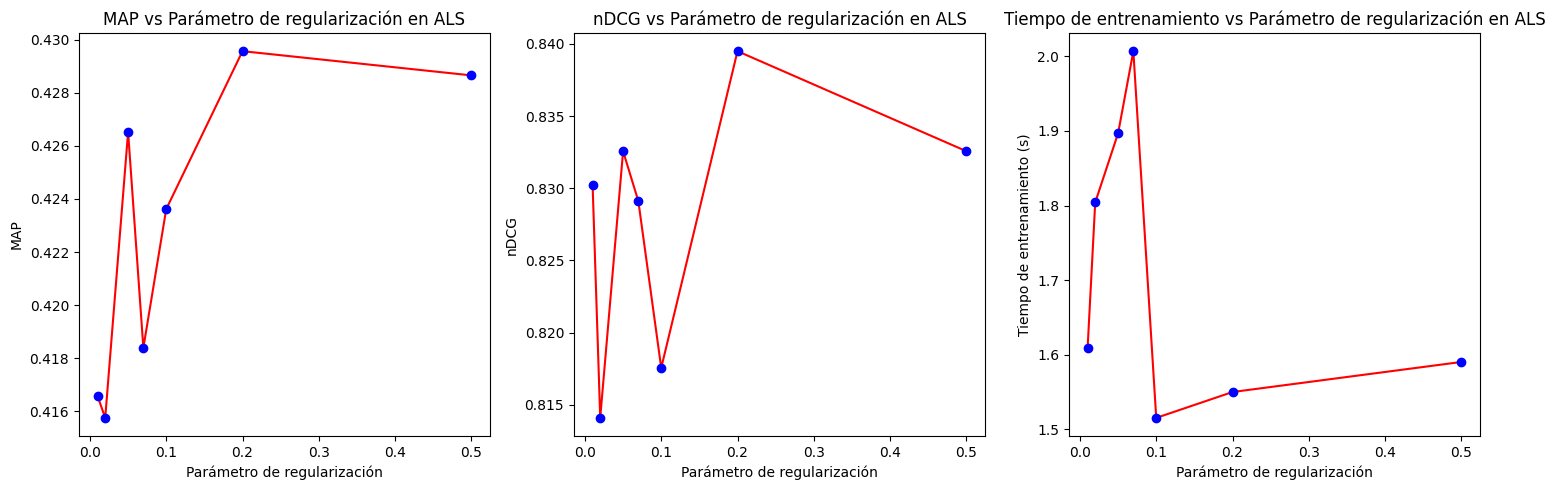

In [19]:
# Crear el grafico para las dos métricas de rendimiento y el tiempo de entrenamiento en funciòn del factor de regularizaciòn
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Grafico map
axs[0].plot(reg_fac_als, map_rg_als, 'r-')
axs[0].plot(reg_fac_als, map_rg_als, 'bo')
axs[0].set_title('MAP vs Parámetro de regularización en ALS')
axs[0].set_xlabel('Parámetro de regularización')
axs[0].set_ylabel('MAP')

# Grafico ndcg
axs[1].plot(reg_fac_als, ndcg_rg_als, 'r-')
axs[1].plot(reg_fac_als, ndcg_rg_als, 'bo')
axs[1].set_title('nDCG vs Parámetro de regularización en ALS')
axs[1].set_xlabel('Parámetro de regularización')
axs[1].set_ylabel('nDCG')

# Grafico time
axs[2].plot(reg_fac_als, train_times_rg_als, 'r-')
axs[2].plot(reg_fac_als, train_times_rg_als, 'bo')
axs[2].set_xlabel('Parámetro de regularización')
axs[2].set_ylabel('Tiempo de entrenamiento (s)')
axs[2].set_title('Tiempo de entrenamiento vs Parámetro de regularización en ALS')


# Ajustar el espaciado entre los subplots
plt.tight_layout()

# Mostrar el gráfico
plt.show()

**Factor de regularización**
Con respecto al factor de regularización, vemos que las métricas tienen variaciones muy bruscas y son muy sensibles a pequeñas variaciones en el factor.
Se observa que **0.2 podría ser un buen valor** pues se maximizan ambas mètricas de evaluación con bajos tiempos de entrenamiento.


##Conclusiones y Mejor Combinación de Hiperparámetros
La elección de la mejor combinación de hiperparámetros depende de la importancia relativa del tiempo de entrenamiento frente al rendimiento del modelo (MAP y nDCG). También es importante tomar en cuenta que cada vez que el modelo es entrenado, se obtiene un resultado distinto, lo que dificulta un escenario óptimo para el análisis.

Si el tiempo de entrenamiento es una consideración crítica, se optaría por aquel modelo que balancee un tiempo de entrenamiento razonable con un buen rendimiento.

**En este caso, un número de factores alrededor de 20 con un factor de regularización de 0.2**


### Actividad 3: Entrenamiento de modelo BPR

Repita el procedimiento de la Actividad 2 para el modelo BPR. Recuerde realizar un estudio de hiperparámetros sobre dos hiperparámetros distintos y exponer sus observaciones, elecciones como mejor combinación de hiperparámetros y realizar un análisis del tiempo de entrenamiento.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de código con sus conclusiones y respuestas.

In [20]:
# Repetimos el mismo proceso pero para BPR
# Utilizamos el mismo hiperparámetro de factores latentes para el entrenamiento de BPR pero ahora consideramos iteraciones
# Factores latentes
# Factor de regularización

factores_bpr = [i*5 for i in range(1, 11)]
reg_fac_bpr = [0.01, 0.02, 0.05, 0.07, 0.1, 0.2, 0.5, 0.8, 1]
it_bpr = [i*10 for i in range(1, 11)]

In [21]:
# Creamos una función para entrenar un modelo y le aplicamos el decorador de tiempo
@timer
def train_model(model):
    model.fit(user_item_matrix, show_progress=False)
    return model

# Entrenamos bajo los hiperparámetros definidos y evaluamos sobre una lista de recomendaciones de largo 10
n = 10

map_f_bpr = []
ndcg_f_bpr = []

map_rg_bpr = []
ndcg_rg_bpr = []

map_it_bpr = []
ndcg_it_bpr = []

train_times_f_bpr = []
train_times_rg_bpr = []
train_times_it_bpr = []

for f in factores_bpr:
    print('Training model with', f, 'latent factors')
    model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=f)   #Ajusto modelo bpr en lugar de ALS
    model_bpr, train_time_f = train_model(model_bpr)
    mmap, ndcg = evaluate_model(model_bpr, n)
    map_f_bpr.append(mmap)
    ndcg_f_bpr.append(ndcg)
    train_times_f_bpr.append(train_time_f)
    print('')

for rg in reg_fac_bpr:
    print('Training model with', rg, 'regularization factor')
    model_bpr = implicit.bpr.BayesianPersonalizedRanking(regularization=rg)   #Ajusto modelo bpr en lugar de ALS
    model_bpr, train_time_rg = train_model(model_bpr)
    mmap, ndcg = evaluate_model(model_als, n)
    map_rg_bpr.append(mmap)
    ndcg_rg_bpr.append(ndcg)
    train_times_rg_bpr.append(train_time_rg)
    print()

for it in it_bpr:
    print('Training model with', it, 'regularization factor')
    model_bpr = implicit.bpr.BayesianPersonalizedRanking(iterations=it)
    model_bpr, train_time_rg = train_model(model_bpr)
    mmap, ndcg = evaluate_model(model_bpr, n)
    map_it_bpr.append(mmap)
    ndcg_it_bpr.append(ndcg)
    train_times_it_bpr.append(train_time_rg)
    print()


Training model with 5 latent factors
Tiempo de ejecución (s): 0.843005895614624

Training model with 10 latent factors
Tiempo de ejecución (s): 0.9178149700164795

Training model with 15 latent factors
Tiempo de ejecución (s): 0.9526851177215576

Training model with 20 latent factors
Tiempo de ejecución (s): 0.9984798431396484

Training model with 25 latent factors
Tiempo de ejecución (s): 1.030465841293335

Training model with 30 latent factors
Tiempo de ejecución (s): 1.0350370407104492

Training model with 35 latent factors
Tiempo de ejecución (s): 1.2043447494506836

Training model with 40 latent factors
Tiempo de ejecución (s): 1.1631171703338623

Training model with 45 latent factors
Tiempo de ejecución (s): 1.339372158050537

Training model with 50 latent factors
Tiempo de ejecución (s): 1.3439300060272217

Training model with 0.01 regularization factor
Tiempo de ejecución (s): 1.7896859645843506

Training model with 0.02 regularization factor
Tiempo de ejecución (s): 1.70865201

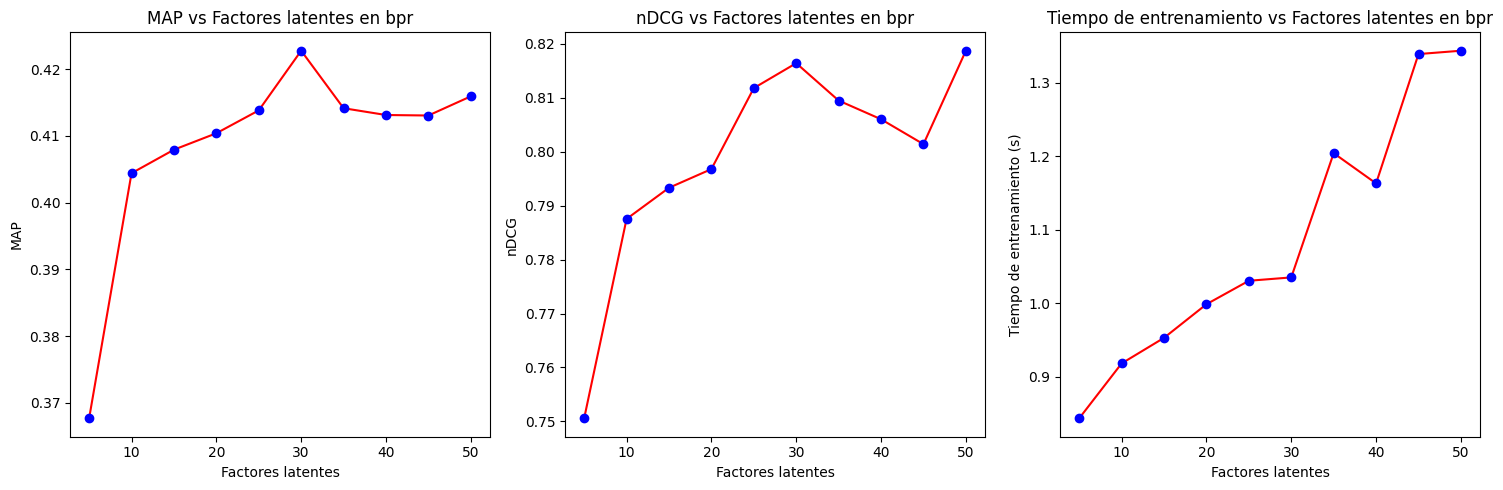

In [22]:
# Crear el grafico para el modelo bpr, para las dos metricas de rendimiento y el tiempo de entrenamiento
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Grafico map
axs[0].plot(factores_bpr, map_f_bpr, 'r-')
axs[0].plot(factores_bpr, map_f_bpr, 'bo')
axs[0].set_title('MAP vs Factores latentes en bpr')
axs[0].set_xlabel('Factores latentes')
axs[0].set_ylabel('MAP')

# Grafico ndcg
axs[1].plot(factores_bpr, ndcg_f_bpr, 'r-')
axs[1].plot(factores_bpr, ndcg_f_bpr, 'bo')
axs[1].set_title('nDCG vs Factores latentes en bpr')
axs[1].set_xlabel('Factores latentes')
axs[1].set_ylabel('nDCG')

# Grafico time
axs[2].plot(factores_bpr, train_times_f_bpr, 'r-')
axs[2].plot(factores_bpr, train_times_f_bpr, 'bo')
axs[2].set_xlabel('Factores latentes')
axs[2].set_ylabel('Tiempo de entrenamiento (s)')
axs[2].set_title('Tiempo de entrenamiento vs Factores latentes en bpr')


# Ajustar el espaciado entre los subplots
plt.tight_layout()

# Mostrar el gráfico
plt.show()

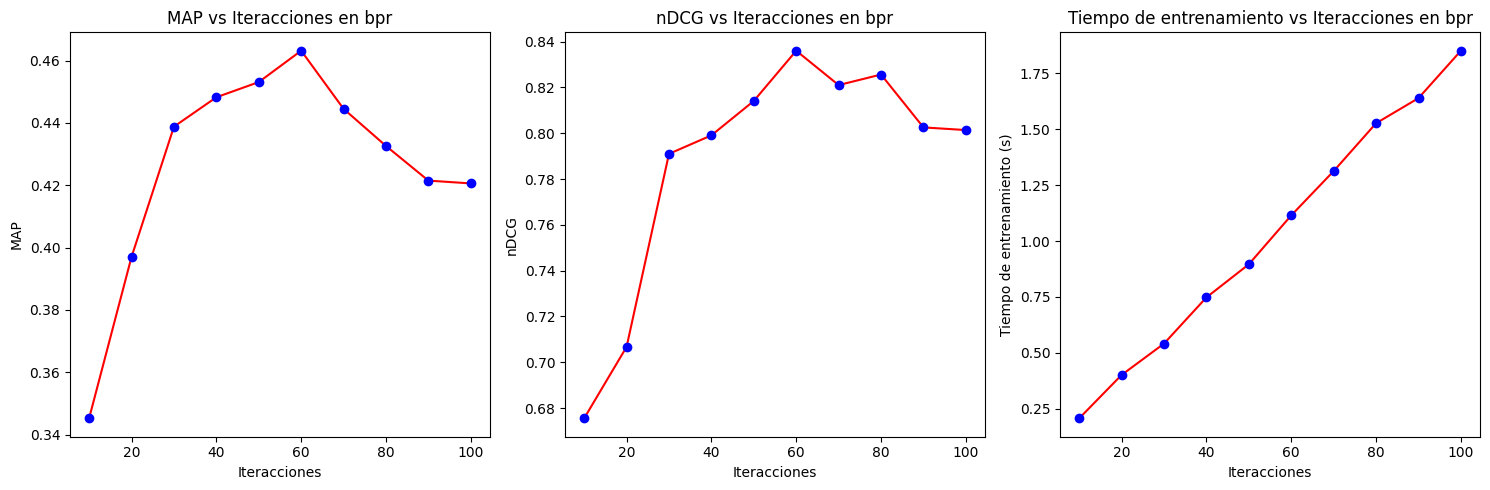

In [23]:
# Crear el grafico para las dos métricas de rendimiento y el tiempo de entrenamiento en funciòn de las iteracciones
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Grafico map
axs[0].plot(it_bpr, map_it_bpr, 'r-')
axs[0].plot(it_bpr, map_it_bpr, 'bo')
axs[0].set_title('MAP vs Iteracciones en bpr')
axs[0].set_xlabel('Iteracciones')
axs[0].set_ylabel('MAP')

# Grafico ndcg
axs[1].plot(it_bpr, ndcg_it_bpr, 'r-')
axs[1].plot(it_bpr, ndcg_it_bpr, 'bo')
axs[1].set_title('nDCG vs Iteracciones en bpr')
axs[1].set_xlabel('Iteracciones')
axs[1].set_ylabel('nDCG')

# Grafico time
axs[2].plot(it_bpr, train_times_it_bpr, 'r-')
axs[2].plot(it_bpr, train_times_it_bpr, 'bo')
axs[2].set_xlabel('Iteracciones')
axs[2].set_ylabel('Tiempo de entrenamiento (s)')
axs[2].set_title('Tiempo de entrenamiento vs Iteracciones en bpr')


# Ajustar el espaciado entre los subplots
plt.tight_layout()

# Mostrar el gráfico
plt.show()

**Conclusiones**
Con **15 factores latentes** se encuentran buenas métricas en el modelo bpr y tiempos de entrenamiento relativamente cortos. El nùmero de iteracciones que maximina las mètricas es del orden de 60. Si bien se observan tiempos de entrenamiento crecientes con el nùmero de interacciones, los tiempos se disparan a partir de 70 iteracciones. Aunque al trabajar con 60 iteracciones se debe aceptar tiempos mayores con un menor número de iteraciones, el valor no llega a ser excesivamente alto, lo que sugiere un equilibrio adecuado entre rendimiento y tiempo de entrenamiento para este valor específico de hiperparámetro. En resumen, se considera que trabajar con **60 iteracciones en el modelo bpr**.

### Actividad 4: Comparación de modelos.

Entrene modelos ALS y BPR con la combinación de hiperparámetros seleccionadas de las actividades 2 y 3. Genere una tabla exponiendo los resultados de ambos modelos al evaluarlos según nDCG@k y MAP@k proporcionadas (son libres de elegir el valor de k). Incluya también el valor del tiempo de entrenamiento empleado.

Además, implemente y agregue a su tabla los resultados usando una métrica adicional estudiada en el curso. Esta métrica puede ser programada por ustedes o usando una función de una librería externa.

Finalmente comente sobre los resultados de la tabla y concluya qué método entregó los mejores resultados para el set de datos utilizado.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de código con sus conclusiones y respuestas.

In [30]:
# Fijamos los valores óptimos de ALS y BPR encontrados anteriormente e instranciamos los modelos
f_opt_als = 20
rg_opt_als = 0.2
f_opt_bpr = 15
it_opt_bpr = 60

opt_als = implicit.als.AlternatingLeastSquares(factors=f_opt_als, regularization=rg_opt_als)
opt_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=f_opt_bpr, iterations=it_opt_bpr)

In [31]:
# Entrenamos los modelos con los valores óptimos
opt_als, train_time_als = train_model(opt_als)
opt_bpr, train_time_bpr = train_model(opt_bpr)

Tiempo de ejecución (s): 0.2592031955718994
Tiempo de ejecución (s): 0.5319020748138428


In [32]:
# Evaluamos ambos modelos con 5 factores latentes, k = 5
k = 5
mmap_als, ndcg_als = evaluate_model(opt_als, k)
mmap_bpr, ndcg_bpr = evaluate_model(opt_bpr, k)

In [33]:
print(mmap_als, ndcg_als)
print(mmap_bpr, ndcg_bpr)

0.5775388119065942 0.8094688221709007
0.4742879137798293 0.6997690531177829


In [34]:
# Ahora, implementamos la métrica AUC para evaluar los recomendadores
import implicit.evaluation

def get_AUC_at_k(model, k):

    auc = implicit.evaluation.AUC_at_k(model,
                                       user_item_matrix,
                                       user_item_matrix_test,
                                       show_progress=False,
                                       K=k
                                    )
    return auc

# Evaluamos ambos modelos con k = 5
k = 5
auc_als = get_AUC_at_k(opt_als, k)
auc_bpr = get_AUC_at_k(opt_bpr, k)

print('AUC para ALS:', auc_als)
print('AUC para BPR:', auc_bpr)


AUC para ALS: 0.5035092676200534
AUC para BPR: 0.5025275326142202


In [35]:
# Definimos una tabla con los resultados obtenidos de los modelos
results = pd.DataFrame({'Modelo': ['ALS', 'BPR'],
                        'MAP': [mmap_als, mmap_bpr],
                        'nDCG': [ndcg_als, ndcg_bpr],
                        'AUC': [auc_als, auc_bpr],
                        'k': [k, k],
                        'Tiempo de entrenamiento (s)': [train_time_als, train_time_bpr]})
results

,Modelo,MAP,nDCG,AUC,k,Tiempo de entrenamiento (s)
0,ALS,0.577539,0.809469,0.503509,5,0.259203
1,BPR,0.474288,0.699769,0.502528,5,0.531902


Podemos ver en nuestro dataframe que el modelo ALS fue más efectivo que el modelo BPR en las métricas `nDCG` y `MAP`. Esto, ya que vemos mejores valores de MAP, nDCG para un `k=5`. Podemos decir en palabras simples que el recomendador `ALS` incluye más ítems en el top 5 que efectivamente están en el set de test, comparado con el recomendador `BPR`.

Podemos ver también que en ambos casos tenemos un AUC en torno al 0.5, lo cual es bajo. Esto nos indica que ambos recomendadores prácticamente son similares a una recomendación aleatoria, con un itemset similar en el ránking. Esta métrica nos indica la proporción de tuplas de ítems ordenadas correctamente en el ránking. Ninguno de los modelos tiene capacidad para ordenar dentro del ránking de los 5 ítems con mejor recomendación si un ítem es mejor que otro con una alta precisión. Lo anterior puede deberse a que puede existir muchos ítems dentro de las recomendaciones que no calzan con el set de test. En el caso de `ALS`, el cual tiene mejores métricas, se podría pensar que si bien tenemos en promedio un porcentaje de 57% de aciertos dentro del top 5 (MAP), dichos ítems podrían estar desordenados con respecto al top 5 real, llevando entonces un AUC bajo. Algo similar parece estar ocurriendo con el recomendador `BPR`.

Finalmente, vemos que el tiempo de entrenamiento es menor en `ALS` que en `BPR`, pero no lo suficiente para que sea determinante y sea una razón de peso para elegir entre uno y otro recomendador.

### Actividad 5: Comparación de modelos con modelo de feedback explícito.

Programe y evalúe un método de filtrado colaborativo de su elección sobre el mismo dataset. Evalúe este sistema y compare su rendimiento con los métodos de ALS y BPR entrenados en actividades anteriores. Recuerde que no todas las métricas son aplicables a sistemas de feedback explícito e implícito, por esto, seleccione al menos una métrica que permita realizar esta comparación. Justifique sus elecciones y concluya en base a los resultados dados.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de código con sus conclusiones y respuestas.

In [36]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 1.3 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp311-cp311-macosx_13_0_arm64.whl size=1109116 sha256=82914a8854066220c4b110728b79926807bec9cec86fe9852cef0fe8e09f0314
  Stored in directory: /Users/ldavico/Library/Caches/pip/wheels/f4/2b/26/e2a5eae55d3b7688995e66abe7f40473aac6c95ddd8ee174a8
Successfully built scikit-surprise

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [37]:
# Utilizaremos el método FunkSVD, el cual es de filtrado colaborativo, y lo entrenaremos
# Preparamos la data
import surprise
from surprise.model_selection import PredefinedKFold


reader = surprise.Reader(line_format='user item rating timestamp', sep='\t', rating_scale=(1,5))
data = surprise.Dataset.load_from_folds([(train_dir, test_dir)], reader=reader)
pkf = PredefinedKFold()
trainset, testset = next(pkf.split(data))


In [38]:
# Importamos SVD y lo entrenamos
from surprise.prediction_algorithms import SVD

# definimos una semilla para poder replicar el resultado
seed = 40

funkSVD = SVD(random_state=seed)
funkSVD.fit(trainset)

In [39]:
# Obtenemos las predicciones
predictions_funk = funkSVD.test(testset)

In [40]:
# Utilizamos la función para calcular nDCG a partir del FunkSVD, dado que es una métrica común a los tres recomendadores
# Rescatado de la ayudantía 2

# Define function to obtain nDCG scores
def get_ndcg(surprise_predictions, k_highest_scores=None):
    """
    Calculates the ndcg (normalized discounted cumulative gain) from surprise predictions, using sklearn.metrics.ndcg_score and scipy.sparse

    Parameters:
    surprise_predictions (List of surprise.prediction_algorithms.predictions.Prediction): list of predictions
    k_highest_scores (positive integer): Only consider the highest k scores in the ranking. If None, use all.

    Returns:
    float in [0., 1.]: The averaged NDCG scores over all recommendations

    """

    from sklearn.metrics import ndcg_score
    from scipy import sparse

    uids = [int(p.uid) for p in surprise_predictions ]
    iids = [int(p.iid) for p in surprise_predictions ]
    r_uis = [p.r_ui for p in surprise_predictions ]
    ests = [p.est for p in surprise_predictions ]

    assert(len(uids) == len(iids) == len(r_uis) == len(ests) )

    sparse_preds = sparse.coo_matrix( (ests, (uids , iids )) )
    sparse_vals = sparse.coo_matrix( (r_uis, (uids , iids )) )

    dense_preds = sparse_preds.toarray()
    dense_vals = sparse_vals.toarray()

    return ndcg_score(y_true= dense_vals , y_score= dense_preds, k=k_highest_scores, ignore_ties=True)

In [41]:
# Obtenemos el nDCG del FunkSVD para un k igual a 5, igual que los análisis anteriores
ndcg_funk = get_ndcg(predictions_funk, k)
print(f'nDCG FunkSVD: {ndcg_funk}')
print (f'nDCG ALS: {ndcg_als}')
(f'nDCG BPR: {ndcg_bpr}')

nDCG FunkSVD: 0.8859791058295942
nDCG ALS: 0.8094688221709007


'nDCG BPR: 0.6997690531177829'

Se obtiene una mejor métrica de rendimiento con el modelo FunkSVD con respecto a los modelos de recomendación implícitos (ALS y BPR).
CG (Normalized Discounted Cumulative Gain) es una métrica comúnmente utilizada para evaluar la calidad de los sistemas de recomendación. Esta métrica tiene en cuenta la relevancia de los elementos recomendados y su posición en la lista de recomendaciones, penalizando los elementos no relevantes que estén en el ránking.

La idea principal detrás de NDCG es que los elementos relevantes que aparecen más arriba en la lista de recomendaciones deberían recibir más peso que los elementos relevantes que aparecen más abajo. Esto se debe a que los usuarios tienden a prestar más atención a los primeros elementos de la lista.

Para calcular NDCG, primero se calcula el DCG (Discounted Cumulative Gain) que mide la relevancia acumulativa de los elementos recomendados en una lista. El DCG se calcula sumando la relevancia de cada elemento dividida por el logaritmo del rango del elemento en la lista más uno.
Luego, se calcula el IDCG (Ideal Discounted Cumulative Gain) que representa el DCG ideal que se obtendría si todos los elementos relevantes estuvieran en las primeras posiciones de la lista. El IDCG se calcula ordenando los elementos relevantes por relevancia y luego calculando el DCG sobre esa lista ordenada.

Finalmente, el NDCG se calcula dividiendo el DCG por el IDCG. Un valor de NDCG cercano a 1 indica que el sistema de recomendación está proporcionando recomendaciones altamente relevantes y bien clasificadas, mientras que un valor cercano a 0 indica lo contrario.

Como se mencionò anteriormente, el modelo FunkSVD parece estar dando mejores resultados que los modelos SVD (Singular Value Decomposition) y BPR (Bayesian Personalized Ranking).

Estamos comparando sistemas de recomendaciones explícitas vs. implícitas (ALS y BPR). FunkSVD se utiliza comúnmente con datos de recomendaciones explícitas, donde las interacciones entre usuarios y elementos están acompañadas de una calificación numérica o alguna forma de retroalimentación explícita. Este tipo de datos proporciona información más directa sobre las preferencias de los usuarios. Para aplicar los modelos ALS y BPR realizamos una transformación asumiendo que los items con calificaciones mayores o iguales a 3 eran relevantes. Aquí de alguna manera perdimos informaciòn pues no logramos capturar la diversidad de las preferencias de los usuarios.

Por otro lado, tenemos datos dispersos y en comparación con BPR y ALS, FunkSVD puede ser menos sensible a la dispersión de los datos, lo que significa que puede funcionar mejor cuando se tienen pocos datos por usuario. BPR, al ser un modelo de optimización basado en pares, puede requerir más datos para entrenarse de manera efectiva.


In [ ]:
def binarize_array(array):
    new_array = list(map(lambda x: 1 if x[0] >= 3 else 0, array))
    return new_array